In [1]:
from model.Transformer import Transformer

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

In [3]:
cols = ['English', 'Hindi', 'annotations']
df = pd.read_csv('data/hin-eng/hin.txt', delimiter='\t', header=None, names = cols)
df.head()

,English,Hindi,annotations
0,Wow!,वाह!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
1,Duck!,झुको!,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Duck!,बतख़!,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Help!,बचाओ!,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
4,Jump.,उछलो.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...


# Preprocess
We will do a simple preprocess of removing the punctuations and making the words in the lower case

In [4]:
import string
def preprocess(x):
    removed_str = x.translate(str.maketrans('', '', string.punctuation))
    return removed_str.lower()

In [5]:
df['English'] = df['English'].apply(preprocess)
df['Hindi'] = df['Hindi'].apply(preprocess)

In [6]:
df.head()

,English,Hindi,annotations
0,wow,वाह,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
1,duck,झुको,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,duck,बतख़,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,help,बचाओ,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
4,jump,उछलो,CC-BY 2.0 (France) Attribution: tatoeba.org #6...


# Vocab
Next would be to create a dictionary mapping from word to idx for both English and Hindi

In [7]:
def create_vocab(series_):
    sent = list(map(str.split, series_))
    flatten_sent = [word for i in sent for word in i]
    words = sorted(list(set(flatten_sent)))
    vocab = {word: idx for idx, word in enumerate(words)}
    return vocab

In [8]:
english_vocab = create_vocab(df['English'])
english_vocab['PAD'] = len(english_vocab)
english_vocab['END'] = len(english_vocab)

In [9]:
hindi_vocab = create_vocab(df['Hindi'])
hindi_vocab['PAD'] = len(hindi_vocab)
hindi_vocab['END'] = len(hindi_vocab)

In [10]:
print("number of words in hindi :   ", len(hindi_vocab))
print("number of words in english : ", len(english_vocab))

number of words in hindi :    3062
number of words in english :  2405


# Dataset

The next step would be to wrap the dataset we have in the form of **pytorch.utils.data.Dataset** This would allow us to use method for efficiently handling batches and handling all data related allocation

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [12]:
class EnglishHindi(Dataset):
    def __init__(self, file_name, english_vocab, hindi_vocab, sentence_length = 10):
        super().__init__()
        self.english_vocab = english_vocab
        self.hindi_vocab = hindi_vocab
        self.sentence_length = sentence_length

        self.x, self.y = [], []
        self.load(file_name)

    def load(self, file_name):
        def preprocess(x):
            removed_str = x.translate(str.maketrans('', '', string.punctuation))
            removed_str = str.split(removed_str.lower())
            removed_str = removed_str+['END']
            if len(removed_str) < self.sentence_length:
                removed_str = removed_str + ['PAD' for _ in range(self.sentence_length - len(removed_str))]
            removed_str = removed_str[:self.sentence_length]
            return removed_str

        mask_pad = lambda x : [1 if i != 'PAD' else 0 for i in x]

        cols = ['English', 'Hindi', 'annotations']
        df = pd.read_csv(f'data/hin-eng/{file_name}', delimiter='\t', header=None, names = cols)

        df['English'] = df['English'].apply(preprocess)
        df['Hindi'] = df['Hindi'].apply(preprocess)

        df['EnglishMask'] = df['English'].apply(mask_pad)
        df['HindiMask'] = df['Hindi'].apply(mask_pad)

        df['English'] = df['English'].apply(lambda x : [self.english_vocab[i] for i in x])
        df['Hindi'] = df['Hindi'].apply(lambda x : [self.hindi_vocab[i] for i in x])

        self.x, self.y = list(df['English']), list(df['Hindi'])
        self.mask_x, self.mask_y = list(df['EnglishMask']), list(df['HindiMask'])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.long)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        mask_x = torch.tensor(self.mask_x[idx], dtype=torch.long)
        mask_y = torch.tensor(self.mask_y[idx], dtype=torch.long)
        return x, y, mask_x, mask_y

In [13]:
file_name = 'hin.txt'
dataset = EnglishHindi(file_name, english_vocab, hindi_vocab)

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [15]:
batch_size = 64

dim = 512
query_key_dim = 256
num_heads = 4
num_stacks = 6

output_vocab_size = len(hindi_vocab)
input_vocab_size = len(english_vocab)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = Transformer(input_vocab_size, output_vocab_size, dim, query_key_dim,
                    num_heads, N=num_stacks, device = device)

In [16]:
model = model.to(device)
optim = torch.optim.Adam(model.parameters(), lr = 3e-5)
loss_fn = nn.CrossEntropyLoss(reduction = 'none')

In [17]:
epochs = 200
history = {'training_loss' : [], 'training_acc':[]}
for epoch in tqdm(range(epochs)):
    loss_, acc_ = [], []
    for _, (x, y, mask_x, mask_y) in enumerate(dataloader):
        x, y, mask_x, mask_y = x.to(device), y.to(device), mask_x.to(device), mask_y.to(device)
        pred, _, _ = model(x, y, mask_x)
        pred_, y_  = pred.reshape(-1, pred.size(-1)), y.reshape(-1)
        mask_y = mask_y.reshape(-1)

        loss = loss_fn(pred_,y_)
        loss = torch.mul(mask_y, loss).mean()
        acc = (torch.argmax(pred_, dim = -1) == y_).sum() / pred_.size(0)

        optim.zero_grad()
        loss.backward()
        optim.step()

        loss_.append(loss.item())
        acc_.append(acc.item())

    loss_, acc_ = np.mean(loss_), np.mean(acc_)
    history['training_loss'].append(loss_)
    history['training_acc'].append(acc_)

    if epoch % 10 == 0:
      print(f"[{epoch}] Loss : {loss_:.4f} Acc : {acc_:.3f}")

  0%|          | 0/200 [00:00<?, ?it/s]

[0] Loss : 5.5570 Acc : 0.079
[10] Loss : 3.7703 Acc : 0.157
[20] Loss : 3.0682 Acc : 0.227
[30] Loss : 2.5158 Acc : 0.290
[40] Loss : 2.4387 Acc : 0.284
[50] Loss : 1.7631 Acc : 0.377
[60] Loss : 1.3015 Acc : 0.453
[70] Loss : 0.9060 Acc : 0.532
[80] Loss : 0.6510 Acc : 0.586
[90] Loss : 0.4891 Acc : 0.614
[100] Loss : 0.5773 Acc : 0.584
[110] Loss : 0.2747 Acc : 0.668
[120] Loss : 0.2496 Acc : 0.673
[130] Loss : 0.3160 Acc : 0.650
[140] Loss : 0.1858 Acc : 0.690
[150] Loss : 0.1443 Acc : 0.703
[160] Loss : 0.6637 Acc : 0.562
[170] Loss : 0.1467 Acc : 0.713
[180] Loss : 0.0807 Acc : 0.727
[190] Loss : 0.0841 Acc : 0.723


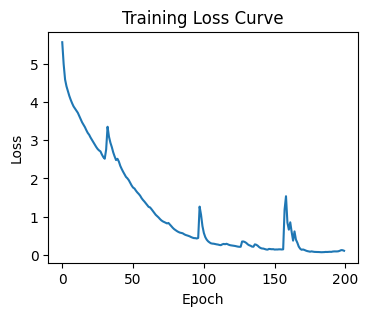

In [18]:
plt.figure(figsize=(4,3))
axs = sns.lineplot(history['training_loss'])
_ = axs.set(xlabel = 'Epoch', ylabel='Loss', title='Training Loss Curve')

We will create an inverted index to get the word given the index in the dictionary

In [19]:
hindi_inverted = { hindi_vocab[key] : key for key in hindi_vocab.keys()}
english_inverted = { english_vocab[key] : key for key in english_vocab.keys()}

In [23]:
with torch.no_grad():
    x_sample, y_sample, mask_x_sample, mask_y_sample = next(iter(dataloader))
    x_sample, y_sample, mask_x_sample =  x_sample.to(device), y_sample.to(device), mask_x_sample.to(device)
    pred_sample, attn_enc, attn_dec = model(x_sample, y_sample,  mask_x_sample)
    pred_sample = torch.argmax(pred_sample, dim = -1)
    predictions = pred_sample.cpu().detach().numpy()

idx = 0

english_words = [english_inverted[idx] for idx in x_sample.cpu().detach().numpy()[idx]]
hindi_words_pred = [hindi_inverted[idx] for idx in predictions[idx]]
hindi_word_actual = [hindi_inverted[idx] for idx in y_sample[idx].cpu().detach().numpy()]

def get_sentence(sentence_list):
    l_ = []
    for i in sentence_list :
        if (i == 'END') or (i == 'PAD') : break
        elif (i=='START') : pass
        else: l_.append(i)
    return l_

english_words = get_sentence(english_words)
hindi_words_pred = get_sentence(hindi_words_pred)
hindi_word_actual = get_sentence(hindi_word_actual)

print("English   :", english_words)
print("Predicted : ", hindi_words_pred)
print("Actual    : ", hindi_word_actual)

English   : ['theyre', 'watching', 'a', 'movie']
Predicted :  ['वे', 'फ़िल्म', 'देख', 'रहे', 'हैं।']
Actual    :  ['वे', 'फ़िल्म', 'देख', 'रहे', 'हैं।']


Next we will look at some attention weights for the last stack and the encoder-decoder attention.

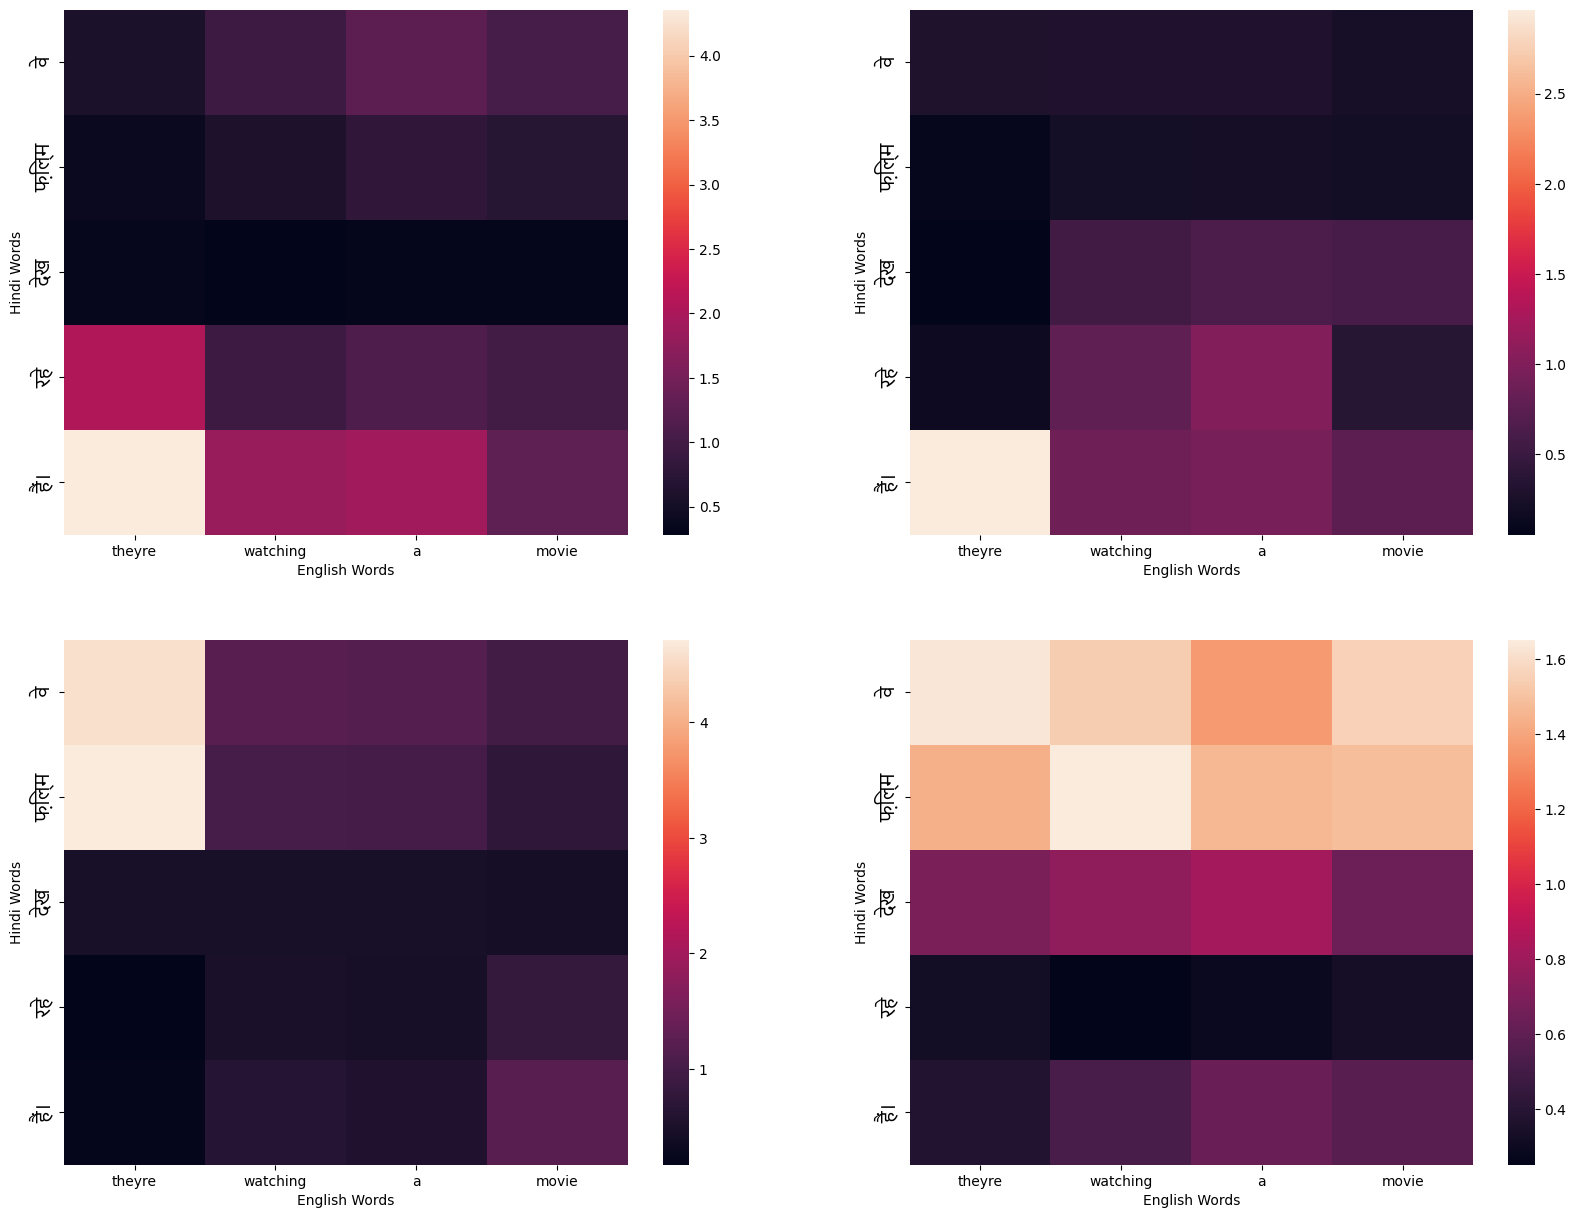

In [24]:
hindi_font = FontProperties(fname='font/Nirmala.ttf', size=14)
_, axs = plt.subplots(2, 2, figsize=(20, 15))
attn_enc = attn_enc.cpu().detach()
for row in range(2):
    for col in range(2):
        axs[row][col] = sns.heatmap(attn_enc[idx, row*2 + col, :len(hindi_words_pred), :len(english_words)].numpy(),
                                    ax =  axs[row][col], cbar=True)
        _ =  axs[row][col].set(xticklabels = english_words,
                               ylabel = 'Hindi Words', xlabel = 'English Words')
        _ =  axs[row][col].set_yticklabels(hindi_words_pred,
                                           fontproperties=hindi_font)